# Setup

In [1]:
import dataloader
import torch
import numpy as np
import argparse
import importlib

In [2]:
# Arguments ===================================
parser = argparse.ArgumentParser()

parser.add_argument('--gpu_id', type=int, default=0)
parser.add_argument('--seed', type=int, default=123)
parser.add_argument('--config', type=str, default='config3.yml')
parser.add_argument('--dataset', type=str, default='cora', choices=['cora', 'citeseer', 'BlogCatalog', 'flickr', 'Polblogs'])
parser.add_argument('--g0_method', type=str, default='random', choices=[
  'random', # randomly distribution of g0
  'bias', # a random class has a 3x higher likelihood of being in g0
  'large_cluster', # a random node and [g0_size] of its neighbors are in g0
  'many_clusters', # 10 random nodes and [g0_size] of their neighbors are in g0
  ])
parser.add_argument('--g0_size', type=float, default=0.1)
parser.add_argument('--attack_method', type=str, default='sll', choices=[
  'sll', # Selective Learnability Lock
  'sll_no_g', # Disable gradient guidance
  'noise', # Noise protection
  'heuristic' # Heuristic protection
  ])
parser.add_argument('--budget_pct', type=float, default=0.25)
parser.add_argument('--attack_epochs', type=int, default=30)
parser.add_argument('--save_results', type=str, default='Y', choices=['N', 'Y'])
parser.add_argument('--save_graph', type=str, default='N', choices=['N', 'Y'])

args = parser.parse_args("")

if args.gpu_id >= 0:
  device = torch.device(f'cuda:{args.gpu_id}' if torch.cuda.is_available() else 'cpu')
else:
  device = torch.device('cpu')

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if device != 'cpu': torch.cuda.manual_seed(args.seed)

import yaml
from yaml import SafeLoader
config = yaml.load(open(args.config), Loader=SafeLoader)[args.dataset]

In [3]:
# Load graph ===================================
graph = dataloader.load_DGL(args.dataset)
feat = graph.ndata['feat'].to(device)
labels = graph.ndata['label'].to(device)
adj = graph.adj().to_dense()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [4]:
def discretize(tensor_a: torch.tensor, n_bins=50, force_bins=False) -> torch.tensor:
    """
    Discretizes a tensor by the number of bins
    """
    print(tensor_a)
    # tensor_a = torch.nn.functional.normalize(tensor_a, dim=0)
    # tensor_a = tensor_a + tensor_a.min()
    if ((not tensor_a.is_floating_point()) and (not tensor_a.is_complex())) and not force_bins:
        return (tensor_a - tensor_a.min()).int()

    tensor_a_max = tensor_a.max().item()
    tensor_a_min = tensor_a.min().item()
    d = tensor_a_max - tensor_a_min

    if d == 0:
        return torch.zeros_like(tensor_a, device=tensor_a.device).int()

    boundaries = torch.arange(start=tensor_a_min, end=tensor_a_max, step = d / n_bins, device=tensor_a.device)
    bucketized = torch.bucketize(tensor_a, boundaries, right=True).to(tensor_a.device)
    result = bucketized - bucketized.min()
    assert result.shape[0] == tensor_a.shape[0]
    return result.int().to(tensor_a.device)

/u/nyw6dh/.conda/envs/pytorch_c116/lib/python3.10/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


(array([ 584.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2124.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

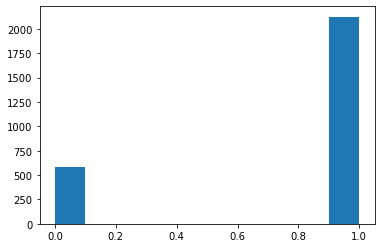

In [6]:
# Select features

import scipy
num_tasks = 2
tasks = torch.zeros((num_tasks, feat.shape[0]), dtype=torch.int64).to(device)

entropies = scipy.stats.entropy(feat.cpu())
entropies[entropies != entropies] = 0
top = torch.from_numpy(entropies).topk(k=5).indices[3]
# top = [1]

tasks[0] = labels
for i, top_entropy in enumerate([top]):
  t = feat[:, top_entropy]
  med = torch.median(t)
  tasks[i + 1] = (t == 0).long().to(device)

feat[:, top] = 0
tasks = tasks.to(device)

import matplotlib.pyplot as plt
plt.hist(tasks[1].cpu().numpy())

In [85]:
import models

class FeatStats:
    def __init__(self, featIdx: int, accMLP: float, accGCN: float) -> None:
        self.featIdx = featIdx
        self.accMLP = accMLP
        self.accGCN = accGCN
        self.delta = (accGCN - accMLP) / accMLP
    
    def __str__(self) -> str:
        return f"<Feat: {self.featIdx} | ∆: {self.delta:.2%}>"

def compareWithMLP(feat: torch.Tensor, adj: torch.Tensor, task_idx: int, train_mask: torch.Tensor, test_mask: torch.Tensor) -> FeatStats:
    featCopy = feat.clone()
    tasks = featCopy[:, task_idx].clone()
    discretizedTasks = (tasks > tasks.median()).long()
    featCopy[:, task_idx] = 0

    comparisonMLP = models.SimpleMLP(
        in_size=feat.shape[1],
        hid_size=config['hid_size'],
        out_size=2,
        lr=config['lr'],
        dropout=config['dropout'],
        weight_decay=config['weight_decay']
    ).to(device)

    comparisonMLP.fit(featCopy, discretizedTasks, 50, train_mask, verbose=False)
    outMLP = comparisonMLP(featCopy).argmax(dim=1)
    accMLP = ((outMLP[test_mask] == discretizedTasks[test_mask]).sum() / test_mask.sum()).item()
    
    comparisonGCN = models.DenseGCN(
        in_size=feat.shape[1],
        hid_size=config['hid_size'],
        out_size=2,
        lr=config['lr'],
        dropout=config['dropout'],
        weight_decay=config['weight_decay']
    ).to(device)

    comparisonGCN.fit(featCopy, adj, discretizedTasks, 50, train_mask, verbose=False)
    outGCN = comparisonGCN(featCopy, adj).argmax(dim=1)
    accGCN = ((outGCN[test_mask] == discretizedTasks[test_mask]).sum() / test_mask.sum()).item()
    
    return FeatStats(task_idx, accMLP, accGCN)

for i in range(444, feat.shape[1]):
    d = compareWithMLP(feat, adj, i, graph.ndata['train_mask'], graph.ndata['test_mask'])
    featResults.append(d)
    print(d)

<Feat: 444 | ∆: 0.00%>
<Feat: 445 | ∆: 0.00%>
<Feat: 446 | ∆: 0.00%>
<Feat: 447 | ∆: 0.00%>
<Feat: 448 | ∆: 0.00%>
<Feat: 449 | ∆: 0.00%>
<Feat: 450 | ∆: 0.00%>
<Feat: 451 | ∆: 0.00%>
<Feat: 452 | ∆: 0.00%>
<Feat: 453 | ∆: 0.00%>
<Feat: 454 | ∆: 0.00%>
<Feat: 455 | ∆: -0.10%>
<Feat: 456 | ∆: 0.00%>
<Feat: 457 | ∆: 0.20%>
<Feat: 458 | ∆: 0.00%>
<Feat: 459 | ∆: 0.00%>
<Feat: 460 | ∆: 0.00%>
<Feat: 461 | ∆: 0.00%>
<Feat: 462 | ∆: 0.00%>
<Feat: 463 | ∆: 0.00%>
<Feat: 464 | ∆: 0.21%>
<Feat: 465 | ∆: 0.00%>
<Feat: 466 | ∆: 0.00%>
<Feat: 467 | ∆: 0.00%>
<Feat: 468 | ∆: 0.00%>
<Feat: 469 | ∆: -0.21%>
<Feat: 470 | ∆: 0.00%>
<Feat: 471 | ∆: 0.00%>
<Feat: 472 | ∆: 0.00%>
<Feat: 473 | ∆: 0.00%>
<Feat: 474 | ∆: -0.52%>
<Feat: 475 | ∆: 0.10%>
<Feat: 476 | ∆: 0.00%>
<Feat: 477 | ∆: 0.00%>
<Feat: 478 | ∆: 0.00%>
<Feat: 479 | ∆: 0.00%>
<Feat: 480 | ∆: 0.00%>
<Feat: 481 | ∆: 0.00%>
<Feat: 482 | ∆: 0.00%>
<Feat: 483 | ∆: 0.00%>
<Feat: 484 | ∆: 0.00%>
<Feat: 485 | ∆: 0.10%>
<Feat: 486 | ∆: 0.00%>
<Feat: 4

In [90]:
featResults.sort(key=lambda x: x.delta, reverse=True)

In [102]:
str(featResults[1].accGCN)

topIdx = map(lambda x: x.featIdx, featResults)
top = torch.tensor(list(topIdx))

[1263,
 1301,
 1138,
 19,
 135,
 1336,
 495,
 99,
 1123,
 1423,
 1328,
 1292,
 729,
 1203,
 130,
 1352,
 969,
 763,
 1392,
 168,
 750,
 1230,
 724,
 581,
 696,
 513,
 128,
 283,
 976,
 619,
 203,
 205,
 749,
 51,
 1325,
 875,
 1132,
 1262,
 1144,
 464,
 1393,
 2,
 1159,
 510,
 1049,
 988,
 588,
 808,
 1114,
 1211,
 417,
 3,
 1005,
 1194,
 126,
 764,
 457,
 123,
 302,
 1215,
 647,
 1118,
 860,
 874,
 39,
 1305,
 1151,
 814,
 1330,
 698,
 978,
 715,
 1247,
 666,
 505,
 625,
 1334,
 1172,
 777,
 1339,
 915,
 1331,
 640,
 756,
 945,
 58,
 378,
 1359,
 718,
 1295,
 1255,
 81,
 44,
 151,
 693,
 1379,
 1387,
 1424,
 416,
 475,
 425,
 1019,
 1079,
 381,
 699,
 1116,
 1140,
 1155,
 194,
 1251,
 121,
 428,
 732,
 854,
 1235,
 27,
 54,
 56,
 315,
 806,
 485,
 757,
 809,
 326,
 922,
 926,
 1022,
 1036,
 15,
 47,
 264,
 965,
 162,
 309,
 801,
 1406,
 900,
 929,
 1416,
 23,
 5,
 632,
 332,
 1080,
 0,
 1,
 4,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 16,
 17,
 18,
 20,
 21,
 22,
 24,
 26,
 28,
 29,
 

In [496]:
# Designate g0 ===================================
g0_size = int(args.g0_size * graph.num_nodes())

def get_clusters(num_roots: int, max_hops: int, target_size: int) -> torch.tensor:
  root_nodes = torch.rand(graph.num_nodes()).topk(num_roots).indices

  for hop in range(max_hops):
    newNodes = adj[root_nodes].nonzero().t()[1]
    root_nodes = torch.cat((root_nodes, newNodes))
    root_nodes = torch.unique(root_nodes)
    if root_nodes.shape[0] >= target_size:
      break

  g0 = torch.zeros(graph.num_nodes())
  g0[root_nodes[:target_size]] = 1
  g0 = g0.bool()
  return g0

if args.g0_method == 'many_clusters': # 10 nodes and their neighbors
  g0 = get_clusters(10, 10, g0_size)
elif args.g0_method == 'large_cluster': # 1 node and its neighbors
  g0 = get_clusters(1, 10, g0_size)
elif args.g0_method == 'random': # g0 is random/bias
  g0_probs = torch.ones(graph.num_nodes())
  g0_probs = g0_probs * (g0_size / g0_probs.sum())
  g0_probs.clamp_(0, 1)
  g0 = torch.bernoulli(g0_probs).bool()
elif args.g0_method == 'bias': # g0 is skewed toward a class by factor of 3
  bias = torch.randint(0, labels.max() + 1, [1]).item()
  print(f'G0 class bias: {bias}')
  g0_probs = torch.ones(graph.num_nodes())
  g0_probs[labels == bias] = 3
  g0_probs = g0_probs * (g0_size / g0_probs.sum())
  g0_probs.clamp_(0, 1)
  g0 = torch.bernoulli(g0_probs).bool()

print(f'G0 size: {g0.sum().item()}')
print(f'G0 pct: {g0.sum().item() / graph.num_nodes():.2%}')

g0 = g0.cpu()
gX = ~g0

G0 size: 285
G0 pct: 10.52%


# Do Attack

In [498]:
# Perform attack ==========================

import utils
import models
import torch.nn.functional as F
from tqdm import tqdm

num_perturbations = (graph.num_edges()) * args.budget_pct

print(f'Attacking with method: {args.attack_method}')

if args.attack_method == 'heuristic':
  locked_adj = adj.clone()
  locked_adj[:, g0] = 0
  locked_adj[g0, :] = 0
elif args.attack_method == 'noise':
  noise = torch.zeros_like(adj)
  noise[g0, :] = 1
  noise[:, gX] = 0
  noise *= 2 * num_perturbations / noise.sum()
  noise = torch.bernoulli(noise.clamp(0, 1))
  noise = utils.make_symmetric(noise)
  locked_adj = utils.get_modified_adj(adj, noise)
elif args.attack_method == 'sll_no_g':

  # Initialize perturbations
  perturbations = torch.zeros_like(adj).float()

  # Create surrogate model to mimic downstream
  surrogates = []
  for task in tasks:
    surrogates.append(models.DenseGCN(
      in_size=feat.shape[1],
      out_size=int(task.max().item())+1,
      hid_size=config['hid_size'],
      lr=config['lr'],
      dropout=config['dropout'],
      weight_decay=config['weight_decay']
  ).to(device))

  t = tqdm(range(args.attack_epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
  t.set_description("SLL (no gradient guidance)")

  for epoch in t:
    # Re-initialize adj_grad
    adj_grad = torch.zeros_like(adj).float()

    # Get modified adj
    modified_adj = utils.get_modified_adj(adj, perturbations).requires_grad_(True).float().to(device)

    # Get grad of modified adj w.r.t attack loss
    loss = 0
    for i, surrogate in enumerate(surrogates):
      pred = surrogate(feat, modified_adj)

      if i == 0:
        loss += F.cross_entropy(pred[g0], tasks[0][g0]) \
            - F.cross_entropy(pred[gX], tasks[0][gX])
      else:
        loss += - F.cross_entropy(pred, tasks[i])

    adj_grad = torch.autograd.grad(loss, modified_adj)[0].cpu()

    # Update perturbations
    lr = (config['sll_no_g_lr']) / ((epoch + 1))
    pre_projection = int(perturbations.sum())
    perturbations = perturbations + (lr * adj_grad)
    perturbations = utils.projection(perturbations, num_perturbations)

    # Train the surrogate
    modified_adj = utils.get_modified_adj(adj, perturbations).to(device)
    model_loss = 0

    for i, surrogate in enumerate(surrogates):
       model_loss += surrogate.fit(feat, modified_adj, tasks[i].to(device), epochs=1, verbose=False)

    t.set_postfix({"adj_l": loss.item(),
                    "adj_g": (adj_grad.sum().item()),
                    "pre-p": pre_projection,
                    "target": int(num_perturbations),
                    "model_loss": model_loss})
elif args.attack_method == 'sll':
  labels = tasks[0].to(device)
  # Initialize perturbations
  perturbations = torch.zeros_like(adj).float()

  # Initialize sampling matrix
  import sampling_matrix
  samplingMatrix = sampling_matrix.SamplingMatrix(
    g0=g0, gX=gX, adj=adj, sample_size=config['sll_sample_size'])
  count = torch.zeros_like(adj).float()

  # Create surrogate model to mimic downstream
  surrogate = models.DenseGCN(
      in_size=feat.shape[1],
      out_size=labels.max().item()+1,
      hid_size=config['hid_size'],
      lr=config['lr'],
      dropout=config['dropout'],
      weight_decay=config['weight_decay']
  ).to(device)

  t = tqdm(range(args.attack_epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
  t.set_description("SLL")

  for epoch in t:
    # Re-initialize adj_grad
    adj_grad = torch.zeros_like(adj).float()

    # Get modified adj
    modified_adj = utils.get_modified_adj(adj, perturbations).float().to(device)

    for sample_epoch in range(config['sll_num_samples']): 
      # Get sample indices
      idx = samplingMatrix.get_sample()

      # Map sample to adj
      sample = modified_adj[idx[0], idx[1]].clone().detach().requires_grad_(True).to(device)
      modified_adj[idx[0], idx[1]] = sample

      # Get grad
      pred = surrogate(feat, modified_adj)
      loss = F.cross_entropy(pred[g0], labels[g0]) \
          - F.cross_entropy(pred[gX], labels[gX])

      grad = torch.autograd.grad(loss, sample)[0]

      # Implement averaging of duplicate samples
      adj_grad[idx[0], idx[1]] += grad.cpu()
      count[idx[0], idx[1]] += 1

    # Update the sampling matrix
    samplingMatrix.updateByGrad(adj_grad, count)

    # Average the gradient
    adj_grad = torch.div(adj_grad, count)
    adj_grad[adj_grad != adj_grad] = 0
    
    # Update perturbations
    lr = (config['sll_lr']) / ((epoch + 1))
    pre_projection = int(perturbations.sum())
    perturbations = perturbations + (lr * adj_grad)
    perturbations = utils.projection(perturbations, num_perturbations)

    # Train the model
    modified_adj = utils.get_modified_adj(adj, perturbations).to(device)
    model_loss = surrogate.fit(feat, modified_adj, labels, epochs=1, verbose=False)

    t.set_postfix({"attack_loss": loss.item(),
                    # "adj_g": (adj_grad.sum().item()),
                    "pre-projection": pre_projection,
                    "target": int(num_perturbations),
                    "surrogate_loss": model_loss})

# Discretize the best locked_adj ============
if args.attack_method in ['sll', 'sll_no_g']:
  locked_adj = None
  with torch.no_grad():
    max_loss = -1000
    for k in range(0,3):
        sample = torch.bernoulli(perturbations)
        modified_adj = utils.get_modified_adj(adj, sample)
        modified_adj = utils.make_symmetric(modified_adj) 

        loss = 0
        for i, surrogate in enumerate(surrogates):
          pred = surrogate(feat, modified_adj.to(device))

          if i == 0:
            loss += F.cross_entropy(pred[g0], tasks[0][g0]) \
                - F.cross_entropy(pred[gX], tasks[0][gX])
          else:
            loss += - F.cross_entropy(pred, tasks[i])

        if loss > max_loss:
            max_loss = loss
            locked_adj = modified_adj
    
    print(f"Best sample loss: {max_loss:.2f}")

diff = adj - locked_adj
print(f'Edges modified: {diff.abs().sum() / 2:.0f}')

Attacking with method: sll


SLL: 100%|██████████| 30/30 [00:08<00:00,  3.62it/s, attack_loss=1.05, pre-projection=2639, target=2639, surrogate_loss=1.56]  


Best sample loss: 0.01
Edges modified: 2601


# Eval

In [499]:
model = models.DenseGCN(
    in_size=feat.shape[1],
    out_size=int(tasks[1].max().item())+1,
    hid_size=config['hid_size'],
    lr=config['lr'],
    dropout=config['dropout'],
    weight_decay=config['weight_decay']
).to(device)

model.fit(feat, adj, tasks[1], 200, mask=graph.ndata['train_mask'])


# f1_g0 = metrics.f1_score(tasks[1][g0_test].cpu(), pred.argmax(dim=1)[g0_test], average='micro')
# f1_gX = metrics.f1_score(tasks[1][gX_test].cpu(), pred.argmax(dim=1)[gX_test], average='micro')

# f1_g0, f1_gX

GCN Training: 100%|██████████| 200/200 [00:02<00:00, 68.77it/s, loss=0.11]


0.10682589560747147

In [500]:
pred = model(feat, adj).cpu().argmax(dim=1)
acc = pred[graph.ndata['test_mask']] == tasks[1][graph.ndata['test_mask']].cpu()
acc.sum() / acc.shape[0]

tensor(0.7440)

In [501]:
# Evaluation ==============================
import sklearn.metrics as metrics
gX_train = torch.logical_and(gX, graph.ndata['train_mask'])
gX_test = torch.logical_and(gX, graph.ndata['test_mask'])
g0_test = torch.logical_and(g0, graph.ndata['test_mask'])


def eval_adj(test_adj: torch.tensor, task):
    model = models.DenseGCN(
        in_size=feat.shape[1],
        out_size=int(task.max().item())+1,
        hid_size=config['hid_size'],
        lr=config['lr'],
        dropout=config['dropout'],
        weight_decay=config['weight_decay']
    ).to(device)

    model.fit(feat, test_adj, task, epochs=100, mask=gX_train)
    pred = model(feat, test_adj).cpu()

    f1_g0 = metrics.f1_score(task[g0_test].cpu(), pred.argmax(dim=1)[g0_test], average='micro')
    f1_gX = metrics.f1_score(task[gX_test].cpu(), pred.argmax(dim=1)[gX_test], average='micro')
    
    return f1_g0, f1_gX

accs = {}
for i, task in enumerate(tasks):
    f1_g0_base, f1_gX_base = eval_adj(adj, task)
    print(f'f1_g0_base: {f1_g0_base}, f1_gX_base: {f1_gX_base} ')
    f1_g0_lock, f1_gX_lock = eval_adj(locked_adj, task)
    print(f'f1_g0_lock: {f1_g0_lock}, f1_gX_lock: {f1_gX_lock} ')
    d_g0 = (f1_g0_lock - f1_g0_base) / f1_g0_base
    d_gX = (f1_gX_lock - f1_gX_base) / f1_gX_base

    accs[f'f1_g0_base_{i}'] = f1_g0_base
    accs[f'f1_gX_base_{i}'] = f1_gX_base
    accs[f'f1_g0_lock_{i}'] = f1_g0_lock
    accs[f'f1_gX_lock_{i}'] = f1_gX_lock
    accs[f'd_g0_{i}'] = d_g0
    accs[f'd_gX_{i}'] = d_gX
    accs[f'num_classes_{i}'] = int(task.max().item())+1

accs


GCN Training: 100%|██████████| 100/100 [00:01<00:00, 85.53it/s, loss=0.18]


f1_g0_base: 0.7263157894736842, f1_gX_base: 0.6928176795580111 


GCN Training: 100%|██████████| 100/100 [00:00<00:00, 108.11it/s, loss=0.31]


f1_g0_lock: 0.35789473684210527, f1_gX_lock: 0.6375690607734806 


GCN Training: 100%|██████████| 100/100 [00:01<00:00, 86.48it/s, loss=0.1]


f1_g0_base: 0.6631578947368421, f1_gX_base: 0.7027624309392265 


GCN Training: 100%|██████████| 100/100 [00:00<00:00, 100.06it/s, loss=0.13]


f1_g0_lock: 0.7368421052631579, f1_gX_lock: 0.7657458563535912 


{'f1_g0_base_0': 0.7263157894736842,
 'f1_gX_base_0': 0.6928176795580111,
 'f1_g0_lock_0': 0.35789473684210527,
 'f1_gX_lock_0': 0.6375690607734806,
 'd_g0_0': -0.5072463768115942,
 'd_gX_0': -0.07974481658692197,
 'num_classes_0': 7,
 'f1_g0_base_1': 0.6631578947368421,
 'f1_gX_base_1': 0.7027624309392265,
 'f1_g0_lock_1': 0.7368421052631579,
 'f1_gX_lock_1': 0.7657458563535912,
 'd_g0_1': 0.11111111111111113,
 'd_gX_1': 0.08962264150943396,
 'num_classes_1': 2}

In [502]:
import importlib
importlib.reload(utils)

H_overall = utils.calc_homophily(adj, labels)

H_g0_base = utils.calc_homophily(adj, labels, g0)
H_gX_base = utils.calc_homophily(adj, labels, gX)
H_g0gX_base = utils.inner_homophily(adj, labels, g0, gX)

H_g0_lock = utils.calc_homophily(locked_adj, labels, g0)
H_gX_lock = utils.calc_homophily(locked_adj, labels, gX)
H_g0gX_lock = utils.inner_homophily(locked_adj, labels, g0, gX)

d_H_g0 = (H_g0_lock - H_g0_base) / H_g0_base
d_H_gX = (H_gX_lock - H_gX_base) / H_gX_base
d_H_g0gX = (H_g0gX_lock - H_g0gX_base) / H_g0gX_base

changes_g0 = diff[g0, :][:, g0].abs().sum().item()
changes_gX = diff[gX, :][:, gX].abs().sum().item()
changes_g0gX = diff.abs().sum().item() - (changes_g0 + changes_gX)

print(f'H Overall: {H_overall:.1%}')
print(f'ACC      f1_g0\tf1_gX\tH_g0\tH_gX\tH_g0gX')
print(f'base   | {f1_g0_base:.1%}\t{f1_gX_base:.1%}\t{H_g0_base:.1%}\t{H_gX_base:.1%}\t{H_g0gX_base:.1%}')
print(f'lock   | {f1_g0_lock:.1%}\t{f1_gX_lock:.1%}\t{H_g0_lock:.1%}\t{H_gX_lock:.1%}\t{H_g0gX_lock:.1%}')
print(f'delta  | {d_g0:.1%}\t{d_gX:.1%}\t{d_H_g0:.1%}\t{d_H_gX:.1%}\t{d_H_g0gX:.1%}')

print(f'Changes')
print(f'g0: {changes_g0}')
print(f'gX: {changes_gX}')
print(f'g0gX: {changes_g0gX}')

H Overall: 81.0%
ACC      f1_g0	f1_gX	H_g0	H_gX	H_g0gX
base   | 66.3%	70.3%	84.6%	81.7%	81.0%
lock   | 73.7%	76.6%	15.9%	80.6%	57.5%
delta  | 11.1%	9.0%	-81.2%	-1.3%	-29.1%
Changes
g0: 1542.0
gX: 176.0
g0gX: 3484.0


In [503]:
# Save the results
import export
import importlib
importlib.reload(utils)

results = {
  'dataset': args.dataset,
  'seed': args.seed,
  'config': args.config,
  'g0_method': args.g0_method,
  'g0_size': args.g0_size,
  'attack_epochs': args.attack_epochs,
  'attack_method': args.attack_method,
  'budget_pct': args.budget_pct,
  'd_g0': d_g0,
  'd_gX': d_gX,
  'H_overall': H_overall,
  'H_g0_base': H_g0_base,
  'H_gX_base': H_gX_base,
  'H_g0gX_base': H_g0gX_base,
  'H_g0_lock': H_g0_lock,
  'H_gX_lock': H_gX_lock,
  'H_g0gX_lock': H_g0gX_lock,
  'd_H_g0': d_H_g0,
  'd_H_gX': d_H_gX,
  'd_H_g0gX': d_H_g0gX,
  'changes_g0': changes_g0,
  'changes_gX': changes_gX,
  'changes_g0gX': changes_g0gX,
  'num_classes': int(labels.max().item()+1),
  'edges_modified': int(diff.abs().sum() / 2),
  'orig_edges': int(adj.sum() / 2)
}
results.update(accs)
export.saveData('./multitask.csv', results)

In [504]:
# if args.save_graph: utils.save_as_dgl(
#   graph, adj, g0, 
#   name=f'{args.dataset} {args.g0_method} {args.attack_method} {args.budget_pct}', 
#   root='./locked/')

In [505]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [506]:
tsne = TSNE(2)

def get_emb(test_adj: torch.tensor, task):
    model = models.DenseGCN(
        in_size=feat.shape[1],
        out_size=int(task.max().item())+1,
        hid_size=config['hid_size'],
        lr=config['lr'],
        dropout=config['dropout'],
        weight_decay=config['weight_decay']
    ).to(device)

    model.fit(feat, test_adj, task, epochs=100, mask=gX_train)
    pred = model(feat, test_adj).cpu()

    return pred



GCN Training: 100%|██████████| 100/100 [00:01<00:00, 92.25it/s, loss=0.2]
/u/nyw6dh/.conda/envs/pytorch_c116/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/u/nyw6dh/.conda/envs/pytorch_c116/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
GCN Training: 100%|██████████| 100/100 [00:01<00:00, 69.94it/s, loss=0.37]
/u/nyw6dh/.conda/envs/pytorch_c116/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/u/nyw6dh/.conda/envs/pytorch_c116/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
GCN Training: 100%|██████████| 10

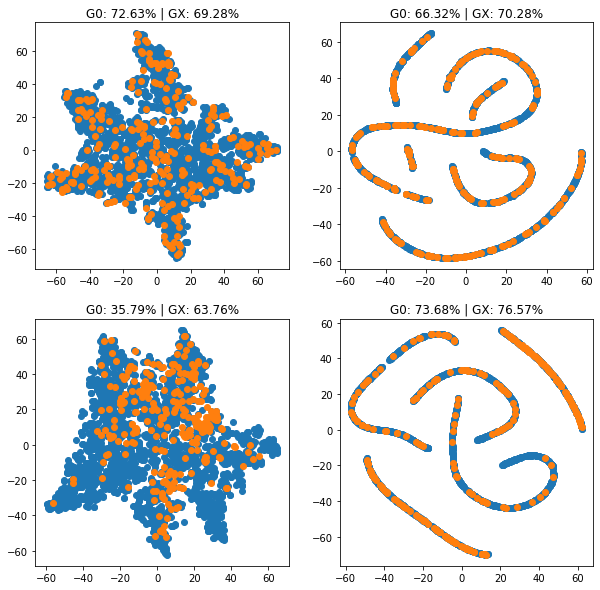

In [507]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

for i, task in enumerate(tasks):
  # Base
  base_pred = get_emb(adj, task)
  tsne_proj = tsne.fit_transform(base_pred.detach())
  X = tsne_proj[gX,0]
  Y = tsne_proj[gX,1]
  axs[0][i].scatter(X, Y, label = 'gX' ,alpha=1)
  X = tsne_proj[g0,0]
  Y = tsne_proj[g0,1]
  axs[0][i].scatter(X, Y, label = 'g0' ,alpha=1)
  k_0 = f'f1_g0_base_{i}'
  k_X = f'f1_gX_base_{i}'
  axs[0][i].title.set_text(f'G0: {accs[k_0]:.2%} | GX: {accs[k_X]:.2%}')
  # axs.legend(fontsize='large', markerscale=2)

  lock_pred = get_emb(locked_adj, task)
  tsne_proj = tsne.fit_transform(lock_pred.detach())
  X = tsne_proj[gX,0]
  Y = tsne_proj[gX,1]
  axs[1][i].scatter(X, Y, label = 'gX' ,alpha=1)
  X = tsne_proj[g0,0]
  Y = tsne_proj[g0,1]
  axs[1][i].scatter(X, Y, label = 'g0' ,alpha=1)
  k_0 = f'f1_g0_lock_{i}'
  k_X = f'f1_gX_lock_{i}'
  axs[1][i].title.set_text(f'G0: {accs[k_0]:.2%} | GX: {accs[k_X]:.2%}')

# plt.title(f"{args.dataset} using {args.attack_method} with G0 selection of {args.g0_method}")
plt.show()

In [508]:
print(f"{args.dataset} using {args.attack_method} with G0 selection of {args.g0_method}")
a = np.array([[accs['d_g0_0'], accs['d_gX_0']], [accs['d_g0_1'], accs['d_gX_1']]])
a

cora using sll with G0 selection of random


array([[-0.50724638, -0.07974482],
       [ 0.11111111,  0.08962264]])

/tmp/ipykernel_208781/2632797467.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['Delta G0', 'Delta GX'])
/tmp/ipykernel_208781/2632797467.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['TASK 0', 'TASK 1'])


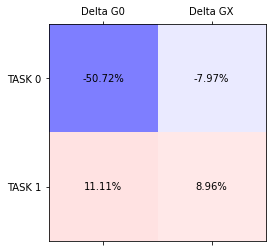

In [509]:
fig, ax = plt.subplots()
ax.matshow(a, vmin=-1, vmax=1, cmap='bwr')
ax.set_xticklabels([''] + ['Delta G0', 'Delta GX'])
ax.set_yticklabels([''] + ['TASK 0', 'TASK 1'])
# Loop over data dimensions and create text annotations.
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        text = ax.text(j, i, f'{a[i, j]:.2%}',
                       ha="center", va="center", color="black")

In [510]:
# Locked
# tsne_proj = tsne.fit_transform(lock_pred.detach())
# fig, ax = plt.subplots(figsize=(8,8))
# X = tsne_proj[gX,0]
# Y = tsne_proj[gX,1]
# ax.scatter(X, Y, label = 'gX' ,alpha=1)
# X = tsne_proj[g0,0]
# Y = tsne_proj[g0,1]
# ax.scatter(X, Y, label = 'g0' ,alpha=1)
# ax.legend(fontsize='large', markerscale=2)
# plt.show()

In [511]:
# print(f"Number of protected nodes: {g0.sum():.0f}")
# print(f"Protected Size: {g0.sum() / graph.num_nodes():.2%}")
# import matplotlib.pyplot as plt
# import numpy as np
# data = labels[g0].cpu().numpy()
# plt.hist(data, bins=np.arange(0, data.max() + 1.5) - 0.5)